In [2]:
!python --version

Python 3.6.13 :: Anaconda, Inc.


In [3]:
!pip show matplotlib

Name: matplotlib
Version: 2.2.5
Summary: Python plotting package
Home-page: http://matplotlib.org
Author: John D. Hunter, Michael Droettboom
Author-email: matplotlib-users@python.org
License: PSF
Location: /home/rudy/anaconda3/envs/py36/lib/python3.6/site-packages
Requires: pytz, six, kiwisolver, numpy, cycler, pyparsing, python-dateutil
Required-by: 


In [4]:
import torch
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

2.5.1+cu121
CUDA available: True
NVIDIA GeForce RTX 5070 Laptop GPU


/home/rudy/.local/lib/python3.10/site-packages/torch/cuda/__init__.py:235: UserWarning: 
NVIDIA GeForce RTX 5070 Laptop GPU with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_50 sm_60 sm_70 sm_75 sm_80 sm_86 sm_90.
If you want to use the NVIDIA GeForce RTX 5070 Laptop GPU GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep
from io import BytesIO
from PIL import Image
import os

import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
from torch.distributions import Categorical

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10,10]

# Env Setup

In [2]:
class diy_env:
    """
    Custom grid environment with image-based rendering.

    Map encoding:
        1 = Start (S)
        0 = Frozen (F)
        -1 = Hole (H)
        2 = Goal (G)

    Image files (128x128):
        start.png, frozen.png, hole.png, goal.png, robot.png (transparent bg)
    """

    def __init__(self, map=np.array([[1,0,0,0],[0,-1,0,-1],[0,0,0,-1],[-1,0,0,2]]),
                 is_slippery=False, success_rate=0.80, reward_schedule=(1, -1, 0),
                 image_dir='./v2/'):
        self.map = map
        self.nrows, self.ncols = map.shape
        self.is_slippery = is_slippery
        self.success_rate = success_rate
        self.reward_schedule = reward_schedule
        self.image_dir = image_dir

        # Find start and goal positions
        self.start_pos = tuple(np.argwhere(map == 1)[0])
        self.goal_pos = tuple(np.argwhere(map == 2)[0])

        # State space
        self.observation_space = type('Space', (), {'n': self.nrows * self.ncols})()
        self.action_space = type('Space', (), {
            'n': 4,
            'sample': lambda self: np.random.randint(0, 4)
        })()

        # Actions: 0=Left, 1=Down, 2=Right, 3=Up
        self.actions = {0: (0, -1), 1: (1, 0), 2: (0, 1), 3: (-1, 0)}
        self.current_pos = None
        self.render_mode = 'rgb_array'

        # Load images (128x128)
        self.images = self._load_images()

    def _load_images(self):
        """Load tile and agent images."""
        images = {}
        try:
            images['start'] = Image.open(os.path.join(self.image_dir, 'start.png')).convert('RGBA')
            images['frozen'] = Image.open(os.path.join(self.image_dir, 'frozen.png')).convert('RGBA')
            images['hole'] = Image.open(os.path.join(self.image_dir, 'hole.png')).convert('RGBA')
            images['goal'] = Image.open(os.path.join(self.image_dir, 'goal.png')).convert('RGBA')
            images['robot'] = Image.open(os.path.join(self.image_dir, 'robot.png')).convert('RGBA')

            # Verify all images are 128x128
            for name, img in images.items():
                if img.size != (128, 128):
                    print(f"Warning: {name}.png is {img.size}, resizing to 128x128")
                    images[name] = img.resize((128, 128), Image.Resampling.LANCZOS)

            return images
        except FileNotFoundError as e:
            print(f"Error loading images: {e}")
            print("Falling back to colored squares")
            return None

    def _pos_to_state(self, pos):
        return pos[0] * self.ncols + pos[1]

    def _state_to_pos(self, state):
        return (state // self.ncols, state % self.ncols)

    def reset(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
        self.current_pos = self.start_pos
        return self._pos_to_state(self.current_pos), {}

    def step(self, action):
        if self.is_slippery and np.random.rand() > self.success_rate:
            action = np.random.choice([a for a in range(4) if a != action])

        dr, dc = self.actions[action]
        next_row = max(0, min(self.nrows - 1, self.current_pos[0] + dr))
        next_col = max(0, min(self.ncols - 1, self.current_pos[1] + dc))
        next_pos = (next_row, next_col)

        cell_value = self.map[next_pos]
        if cell_value == 2:
            reward = self.reward_schedule[0]
            terminated = True
        elif cell_value == -1:
            reward = self.reward_schedule[1]
            terminated = True
        elif cell_value == 1:
            reward = 0
            terminated=False
        else:
            reward = self.reward_schedule[2]
            terminated = False

        self.current_pos = next_pos
        next_state = self._pos_to_state(next_pos)
        truncated = False
        info = {}

        return next_state, reward, terminated, truncated, info

    def render(self):
        """
        Render using custom 128x128 images.
        """
        if self.images is None:
            return self._render_fallback()

        # Create canvas (128px per tile)
        tile_size = 128
        canvas_width = self.ncols * tile_size
        canvas_height = self.nrows * tile_size
        canvas = Image.new('RGBA', (canvas_width, canvas_height), (255, 255, 255, 255))

        # Place tiles
        for i in range(self.nrows):
            for j in range(self.ncols):
                val = self.map[i, j]

                # Select tile image
                if val == 1:
                    tile_img = self.images['start']
                elif val == 2:
                    tile_img = self.images['goal']
                elif val == -1:
                    tile_img = self.images['hole']
                else:
                    tile_img = self.images['frozen']

                # Paste tile
                x = j * tile_size
                y = i * tile_size
                canvas.paste(tile_img, (x, y), tile_img)

        # Overlay robot at current position
        r, c = self.current_pos
        robot_x = c * tile_size
        robot_y = r * tile_size
        canvas.paste(self.images['robot'], (robot_x, robot_y), self.images['robot'])

        # Convert to RGB array
        img_array = np.array(canvas.convert('RGB'))
        return img_array

    def _render_fallback(self):
        """Fallback to colored squares if images not found."""
        fig, ax = plt.subplots(figsize=(self.ncols, self.nrows))
        ax.set_xlim(-0.5, self.ncols - 0.5)
        ax.set_ylim(-0.5, self.nrows - 0.5)
        ax.set_aspect('equal')
        ax.axis('off')

        colors = {'S': '#87CEEB', 'F': '#E0F7FA', 'H': '#263238', 'G': '#4CAF50', 'A': '#FF6B6B'}

        display_map = np.full((self.nrows, self.ncols), 'F', dtype=str)
        for i in range(self.nrows):
            for j in range(self.ncols):
                val = self.map[i, j]
                if val == 1: display_map[i, j] = 'S'
                elif val == 2: display_map[i, j] = 'G'
                elif val == -1: display_map[i, j] = 'H'

        r, c = self.current_pos
        display_map[r, c] = 'A'

        for i in range(self.nrows):
            for j in range(self.ncols):
                char = display_map[i, j]
                color = colors.get(char, 'white')
                rect = plt.Rectangle((j - 0.45, self.nrows - i - 1.45), 0.9, 0.9,
                                   facecolor=color, edgecolor='black', linewidth=2)
                ax.add_patch(rect)
                text = '●' if char == 'A' else char
                fontsize = 24 if char == 'A' else 16
                ax.text(j, self.nrows - i - 1, text, ha='center', va='center',
                       fontsize=fontsize, fontweight='bold',
                       color='white' if char in ['H', 'A'] else 'black')

        fig.canvas.draw()
        buf = BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', pad_inches=0.1)
        buf.seek(0)
        img = Image.open(buf)
        img_array = np.array(img)
        plt.close(fig)
        return img_array

In [3]:
def has_path(map_arr):
    """
    Check if there is at least one path from start (1) to goal (2)
    avoiding holes (-1) using BFS.
    """
    nrows, ncols = map_arr.shape
    starts = np.argwhere(map_arr == 1)
    goals = np.argwhere(map_arr == 2)
    if len(starts) == 0 or len(goals) == 0:
        return False
    start = tuple(starts[0])
    goal = tuple(goals[0])

    q = deque([start])
    visited = set([start])
    moves = [(-1,0),(1,0),(0,-1),(0,1)]

    while q:
        r, c = q.popleft()
        if (r, c) == goal:
            return True
        for dr, dc in moves:
            nr, nc = r + dr, c + dc
            if 0 <= nr < nrows and 0 <= nc < ncols:
                if map_arr[nr, nc] != -1 and (nr, nc) not in visited:
                    visited.add((nr, nc))
                    q.append((nr, nc))
    return False

def make_task2_map(n=10, hole_ratio=0.25, max_tries=1000, rng=None):
    """
    Create an n×n map with:
      - Start at (0,0) encoded as 1
      - Goal at (n-1,n-1) encoded as 2
      - Holes (-1) in ~hole_ratio of cells, excluding start and goal
      - Remaining cells 0 (frozen)
    Ensures at least one path from start to goal.
    """
    if rng is None:
        rng = np.random.default_rng()

    total_cells = n * n
    num_holes = int(round(hole_ratio * total_cells))

    for _ in range(max_tries):
        m = np.zeros((n, n), dtype=int)
        # Place start and goal
        m[0, 0] = 1
        m[-1, -1] = 2

        # Candidate cells for holes (exclude start and goal)
        candidates = [(r, c) for r in range(n) for c in range(n)
                      if (r, c) not in [(0, 0), (n-1, n-1)]]
        hole_cells = rng.choice(len(candidates), size=num_holes, replace=False)
        for idx in hole_cells:
            r, c = candidates[idx]
            m[r, c] = -1

        if has_path(m):
            return m

    raise RuntimeError("Failed to generate a valid map with a path after many tries.")
def plot_rewards_moving_avg(rewards, window=500, title=None):
    rewards = np.array(rewards, dtype=float)
    if title is None:
        title = f"Reward (window={window})"
    plt.figure(figsize=(8, 4))
    #plt.plot(rewards, alpha=0.2, label="Reward per episode")

    if len(rewards) >= window:
        kernel = np.ones(window) / window
        mov_avg = np.convolve(rewards, kernel, mode="valid")
        plt.plot(
            np.arange(window - 1, len(rewards)),
            mov_avg,
            label=f"{window}-episode moving average",
            color="C1",
        )

    plt.xlabel("Episode")
    plt.ylabel("Total reward")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()
def rollout_greedy(env, q_table, max_steps_factor=10):
    """
    Follow greedy policy from start until termination or step cap.
    Returns list of visited states.
    """
    nrows, ncols = env.map.shape
    max_steps = max_steps_factor * nrows * ncols

    states = []
    state, _ = env.reset()
    done = False
    steps = 0

    while not done and steps < max_steps:
        states.append(state)
        action = int(np.argmax(q_table[state]))
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        state = next_state
        steps += 1

    states.append(state)  # include final state
    return states
def plot_trajectory_static(env, q_table, max_steps_factor=10,
                           path_color="red", path_width=6,
                           show_grid=True, title="Greedy trajectory (static)"):
    """
    Draw a single static figure:
      - background = tiled PNGs from env.image_dir (start/frozen/hole/goal)
      - overlay = greedy path as a polyline through tile centers
    Falls back to your old color-block rendering if images are unavailable.
    """
    # Rollout path (states -> (row, col))
    states = rollout_greedy(env, q_table, max_steps_factor=max_steps_factor)
    positions = [env._state_to_pos(s) for s in states]
    rows = np.array([r for (r, c) in positions], dtype=int)
    cols = np.array([c for (r, c) in positions], dtype=int)

    # If images missing, use your previous color-block implementation
    if getattr(env, "images", None) is None:
        return plot_trajectory_static_colorblocks(env, q_table, max_steps_factor=max_steps_factor)

    # Infer tile size from loaded assets (expects square tiles)
    tile_size = env.images["frozen"].size[0]

    # ---- Build background (tiles only; no robot) ----
    canvas_w = env.ncols * tile_size
    canvas_h = env.nrows * tile_size
    canvas = Image.new("RGBA", (canvas_w, canvas_h), (255, 255, 255, 255))

    for i in range(env.nrows):
        for j in range(env.ncols):
            val = env.map[i, j]
            if val == 1:
                tile_img = env.images["start"]
            elif val == 2:
                tile_img = env.images["goal"]
            elif val == -1:
                tile_img = env.images["hole"]
            else:
                tile_img = env.images["frozen"]

            x = j * tile_size
            y = i * tile_size
            canvas.paste(tile_img, (x, y), tile_img)

    bg = np.array(canvas.convert("RGB"))

    # ---- Convert grid positions -> pixel centers ----
    xs = cols * tile_size + tile_size / 2.0
    ys = rows * tile_size + tile_size / 2.0

    # ---- Plot ----
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(bg, origin="upper")  # important for row/col to align visually

    # Path line + markers
    ax.plot(xs, ys, color=path_color, linewidth=path_width, marker="o", markersize=4)
    ax.scatter([xs[0]], [ys[0]], c="yellow", edgecolors="black", s=120, zorder=5, label="Start")
    ax.scatter([xs[-1]], [ys[-1]], c="lime", edgecolors="black", s=120, zorder=5, label="End")

    # Optional grid at tile boundaries
    if show_grid:
        ax.set_xticks(np.arange(0, canvas_w + 1, tile_size))
        ax.set_yticks(np.arange(0, canvas_h + 1, tile_size))
        ax.grid(True, color="black", linewidth=0.8, alpha=0.25)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(length=0)

    ax.set_title(title)
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

# ENVs

### generate the default preset map of size 4x4 (for Task 1)

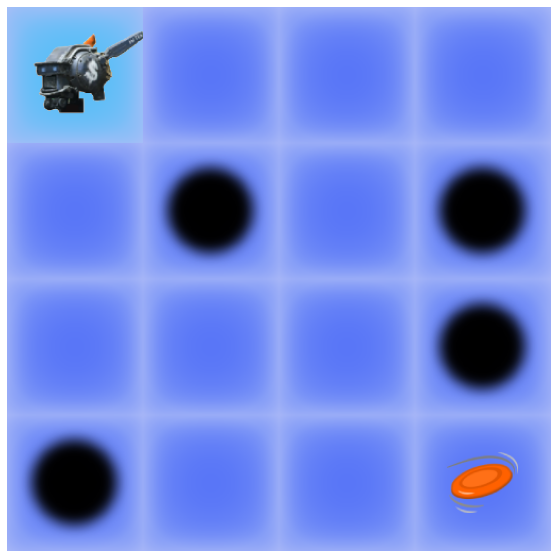

In [4]:
t1_env = diy_env(is_slippery=False, reward_schedule=(1,-1,0))
t1_env.reset()
plt.imshow(t1_env.render())
plt.axis('off')
plt.show()

### generate a solvable random map of size nxn (task 2) (15x15 for now)

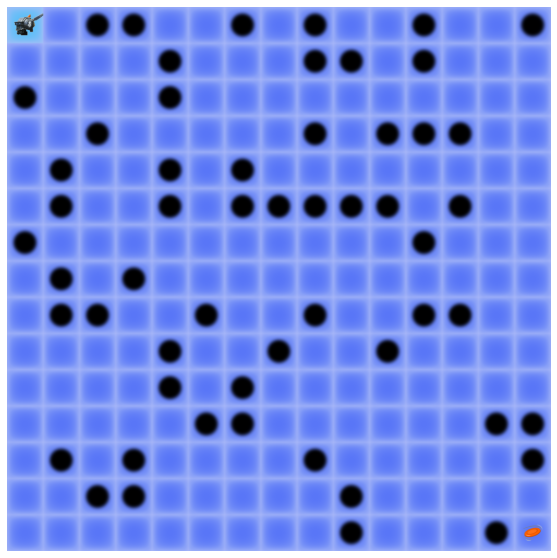

In [5]:
#generate a random nxn solvable map 
task2_map = make_task2_map(n=15, hole_ratio=0.25)
task2_map = np.array([[ 1, 0,-1,-1, 0, 0,-1, 0,-1, 0, 0,-1, 0, 0,-1],
             [ 0, 0, 0, 0,-1, 0, 0, 0,-1,-1, 0,-1, 0, 0, 0],
             [-1, 0, 0, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0,-1, 0, 0, 0, 0, 0,-1, 0,-1,-1,-1, 0, 0],
             [ 0,-1, 0, 0,-1, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0],
             [ 0,-1, 0, 0,-1, 0,-1,-1,-1,-1,-1, 0,-1, 0, 0],
             [-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,-1, 0, 0, 0],
             [ 0,-1, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
             [ 0,-1,-1, 0, 0,-1, 0, 0,-1, 0, 0,-1,-1, 0, 0],
             [ 0, 0, 0, 0,-1, 0, 0,-1, 0, 0,-1, 0, 0, 0, 0],
             [ 0, 0, 0, 0,-1, 0,-1, 0, 0, 0, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0,-1,-1, 0, 0, 0, 0, 0, 0,-1,-1],
             [ 0,-1, 0,-1, 0, 0, 0, 0,-1, 0, 0, 0, 0, 0,-1],
             [ 0, 0,-1,-1, 0, 0, 0, 0, 0,-1, 0, 0, 0, 0, 0],
             [ 0, 0, 0, 0, 0, 0, 0, 0, 0,-1, 0, 0, 0,-1, 2]])
t2_env = diy_env(
    map=task2_map,
    is_slippery=False,
    reward_schedule=(1, -1, 0.0)
)
t2_env.reset()
plt.figure(figsize=(10,10))
plt.imshow(t2_env.render())
plt.axis('off')
plt.show()

# Q-learning (epsilon-greedy)

In [6]:
def learn_q(
    env,
    episodes=50000,
    alpha=0.2,
    gamma=0.95,
    epsilon=0.8,
    epsilon_decay=0.9995,
    epsilon_min=0.05,
    alpha_decay=0.9999,
    alpha_min=0.05,
    max_steps_factor=4,
    verbose=2000
):
    """
    Tabular Q-learning on discrete diy_env.

    max_steps_factor * (nrows * ncols) is a cap on episode length
    to prevent endless wandering on large grids.
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n

    #Q = np.zeros((n_states, n_actions), dtype=np.float32)
    Q = np.ones((n_states, n_actions), dtype=np.float32)*2
    
    rewards_per_ep = []

    nrows, ncols = env.map.shape
    max_steps = max_steps_factor * nrows * ncols

    for ep in range(episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0.0
        steps = 0

        # decay per episode
        alpha = max(alpha_min, alpha * alpha_decay)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        while not done and steps < max_steps:
            # epsilon-greedy
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            # Q-learning update
            best_next = np.max(Q[next_state])
            td_target = reward + gamma * best_next * (0.0 if done else 1.0)
            td_error = td_target - Q[state, action]
            Q[state, action] += alpha * td_error

            state = next_state
            total_reward += reward
            steps += 1

        rewards_per_ep.append(total_reward)

        if (ep + 1) % verbose == 0:
            recent = np.mean(rewards_per_ep[-1*verbose:])
            print(
                f"Ep {ep+1:6d} | avg last {verbose}: {recent:7.3f} "
                f"| alpha: {alpha:.3f} | epsilon: {epsilon:.3f}"
            )

    return Q, rewards_per_ep
def vis(env, q_table, ep=5, sl_t=0.5, end_sl_t=5):
  for _ in range(ep):
        state = env.reset()[0]
        done = False
        while not done:
            clear_output(wait=True)
            plt.imshow(env.render())
            plt.axis('off')
            plt.show()
            sleep(sl_t)

            action = np.argmax(q_table[state])
            state, reward, done, truncated, info = env.step(action)

        clear_output(wait=True)
        plt.imshow(env.render())
        plt.axis('off')
        plt.show()
        sleep(end_sl_t)

## Task 1 using Q-Learning

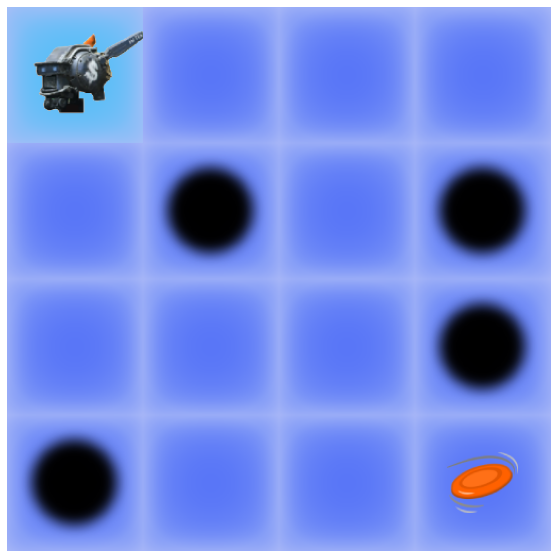

Ep    200 | avg last 200:   0.520 | alpha: 0.300 | epsilon: 0.100
Ep    400 | avg last 200:   0.750 | alpha: 0.299 | epsilon: 0.100
Ep    600 | avg last 200:   0.900 | alpha: 0.299 | epsilon: 0.100
Ep    800 | avg last 200:   0.760 | alpha: 0.299 | epsilon: 0.100
Ep   1000 | avg last 200:   0.740 | alpha: 0.299 | epsilon: 0.100
Ep   1200 | avg last 200:   0.690 | alpha: 0.298 | epsilon: 0.100
Ep   1400 | avg last 200:   0.730 | alpha: 0.298 | epsilon: 0.100
Ep   1600 | avg last 200:   0.760 | alpha: 0.298 | epsilon: 0.100
Ep   1800 | avg last 200:   0.710 | alpha: 0.297 | epsilon: 0.100
Ep   2000 | avg last 200:   0.840 | alpha: 0.297 | epsilon: 0.100


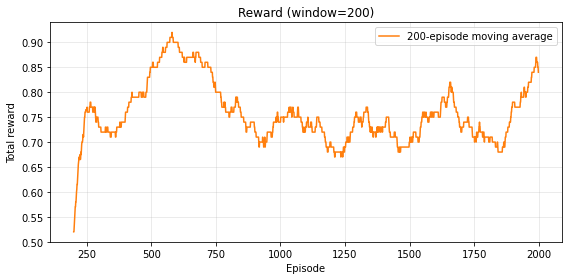

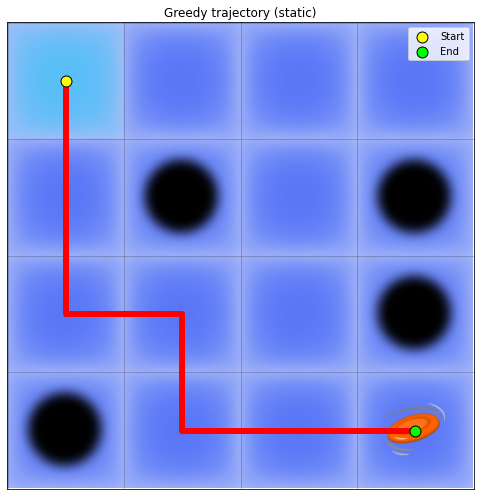

In [7]:
t1_env.reset()
plt.imshow(t1_env.render())
plt.axis('off')
plt.show()

Q_t, r_pep = learn_q(
    t1_env,
    episodes=2000,        # More episodes for 10×10
    alpha=0.3,              # Higher initial learning rate
    gamma=0.9,             # More farsighted
    epsilon=0.1,           # Start with high exploration
    epsilon_decay=1,   # Much slower decay
    alpha_decay=0.999995,
    alpha_min=0.1,
    max_steps_factor=2,      # Allow longer episodes
    verbose=200
)
#plot_rewards(r_pep)
plot_rewards_moving_avg(r_pep, window=200)
plot_trajectory_static(t1_env, Q_t)

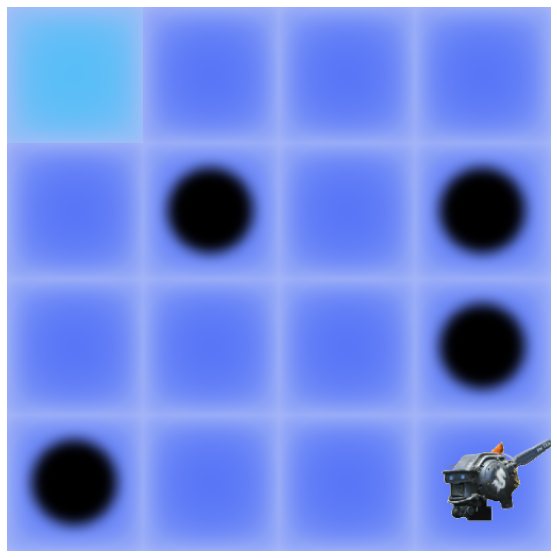

In [8]:
vis(t1_env,Q_t, ep=2, sl_t=0.1, end_sl_t=0.35)

In [9]:
print(Q_t)

[[ 0.5314414   0.59049034  0.59049034  0.5314414 ]
 [ 0.64087117 -0.27792937  0.6561003   0.60217416]
 [ 0.61891735  0.7290002   0.6385509   0.6766379 ]
 [ 0.6671277  -0.27956262  0.658781    0.6684021 ]
 [ 0.59049034  0.6561003  -0.99999994  0.5314414 ]
 [ 2.          2.          2.          2.        ]
 [-0.8774208   0.8100002  -0.4953676   0.7319628 ]
 [ 2.          2.          2.          2.        ]
 [ 0.6561003  -0.99999994  0.7290002   0.59049034]
 [ 0.6561003   0.8100002   0.8100002  -0.99999994]
 [ 0.73669434  0.90000015 -0.27929413  0.734408  ]
 [ 2.          2.          2.          2.        ]
 [ 2.          2.          2.          2.        ]
 [-0.9999998   0.8100002   0.90000015  0.7290017 ]
 [ 0.810001    0.90000015  1.0000001   0.8100002 ]
 [ 2.          2.          2.          2.        ]]


## Task 2 using Q-Learning

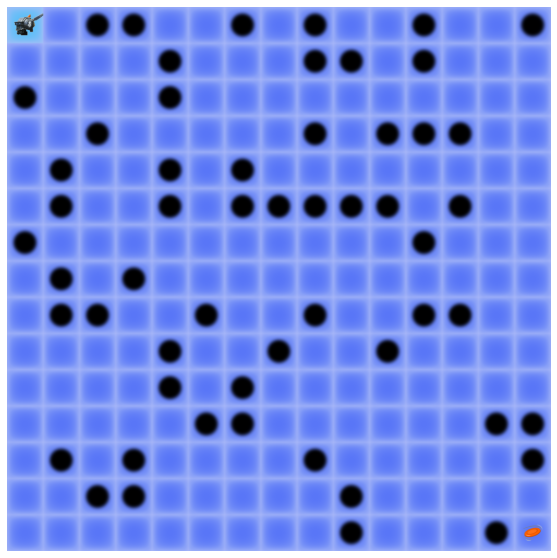

Ep   1000 | avg last 1000:  -1.000 | alpha: 0.299 | epsilon: 0.184
Ep   2000 | avg last 1000:  -0.756 | alpha: 0.297 | epsilon: 0.068
Ep   3000 | avg last 1000:   0.420 | alpha: 0.296 | epsilon: 0.050
Ep   4000 | avg last 1000:   0.588 | alpha: 0.294 | epsilon: 0.050
Ep   5000 | avg last 1000:   0.578 | alpha: 0.293 | epsilon: 0.050
Ep   6000 | avg last 1000:   0.556 | alpha: 0.291 | epsilon: 0.050
Ep   7000 | avg last 1000:   0.486 | alpha: 0.290 | epsilon: 0.050
Ep   8000 | avg last 1000:   0.544 | alpha: 0.288 | epsilon: 0.050
Ep   9000 | avg last 1000:   0.582 | alpha: 0.287 | epsilon: 0.050
Ep  10000 | avg last 1000:   0.558 | alpha: 0.285 | epsilon: 0.050


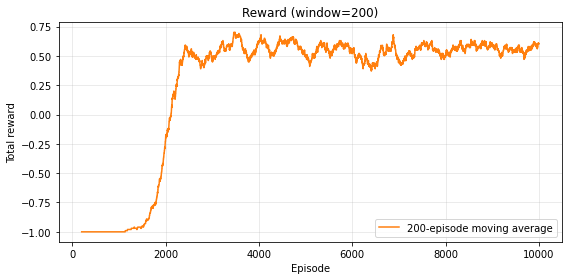

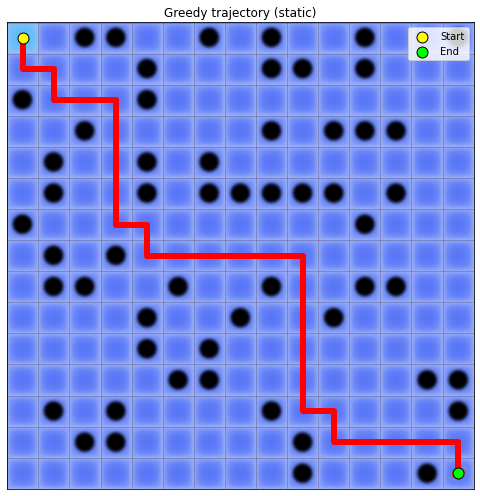

In [10]:
t2_env.reset()
plt.figure(figsize=(10,10))
plt.imshow(t2_env.render())
plt.axis('off')
plt.show()

Q_t_2, r_pep_2 = learn_q(
    t2_env,
    episodes=10000,        # More episodes for 10×10
    alpha=0.3,              # Higher initial learning rate
    gamma=0.9,             # More farsighted
    epsilon=0.5,           # Start with high exploration
    epsilon_decay=0.999,   # Much slower decay
    alpha_decay=0.999995,
    alpha_min=0.1,
    max_steps_factor=2,     # Allow longer episodes
    verbose=1000
)
#plot_rewards(r_pep)
plot_rewards_moving_avg(r_pep_2, window=200)
plot_trajectory_static(t2_env, Q_t_2)

In [11]:
print(Q_t_2)

[[ 0.05233491  0.05814989  0.05814989  0.05233491]
 [ 0.05305841  0.06461099 -0.99999994  0.05857319]
 [ 2.          2.          2.          2.        ]
 [ 2.          2.          2.          2.        ]
 [-0.4909733  -0.93943965  0.13276848  0.13288325]
 [ 0.1328901   0.13571593 -0.970253    0.13563356]
 [ 2.          2.          2.          2.        ]
 [-0.4918361   0.14963642 -0.748628    0.150511  ]
 [ 2.          2.          2.          2.        ]
 [-0.91302615 -0.641086    0.20085222  0.19561507]
 [ 0.19736063  0.20037338 -0.82311416  0.20034035]
 [ 2.          2.          2.          2.        ]
 [-0.8229524   0.22878903  0.23476645  0.23513925]
 [ 0.23675281  0.23133565 -0.2726381   0.23151489]
 [ 2.          2.          2.          2.        ]
 [ 0.05814989 -0.99999994  0.06461099  0.05233491]
 [ 0.05814989  0.07178998  0.07178998  0.05814989]
 [ 0.06876016  0.07976663  0.07976663 -0.99999994]
 [ 0.07970677  0.08862958 -0.99996465 -0.99999994]
 [ 2.          2.          2.  

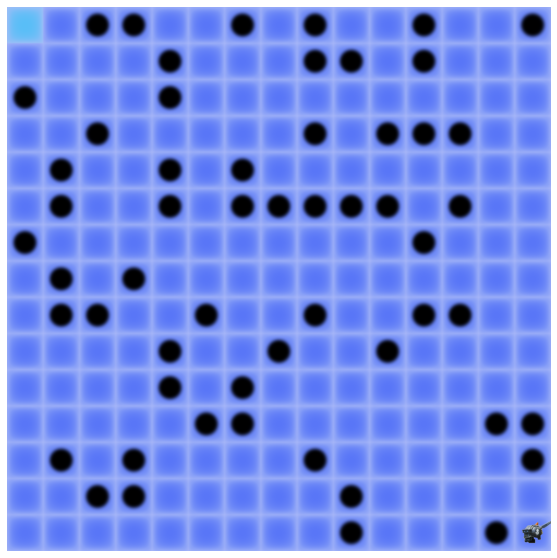

In [12]:
vis(t2_env,Q_t_2, ep=2, sl_t=0.1, end_sl_t=0.35)

# First Visit MC

In [13]:
def epsilon_soft_policy(state, Q, n_actions, epsilon=0.1):
    """Epsilon-soft policy: greedy + uniform exploration."""
    argmax_a = np.argmax(Q[state])
    p_greedy = (1 - epsilon) + (epsilon / n_actions)
    p_other = epsilon / n_actions
    probs = np.full(n_actions, p_other)
    probs[argmax_a] = p_greedy
    return probs


def first_visit_mc_control(env, episodes=100000, gamma=0.9, epsilon=0.1):
    """
    On-policy First-Visit MC Control for epsilon-soft policies.
    No exploring starts needed.

    Returns:
        Q: Learned Q-table [state x action]
        rewards_per_ep: List of episode rewards
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = np.zeros((n_states, n_actions))
    N = np.zeros((n_states, n_actions))  # Visit counts
    rewards_per_ep = []

    for i in range(episodes):
        episode = []  # List of (state, action, reward)
        state, _ = env.reset()
        done = False

        while not done:
            probs = epsilon_soft_policy(state, Q, n_actions, epsilon)
            action = np.random.choice(n_actions, p=probs)
            next_state, reward, terminated, truncated, _ = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            done = terminated or truncated

        # First-visit returns
        G = 0
        visited_sa = set()
        for t in reversed(range(len(episode))):
            state, action, reward = episode[t]
            sa = (state, action)
            G = reward + gamma * G
            if sa not in visited_sa:
                N[state, action] += 1
                Q[state, action] += (G - Q[state, action]) / N[state, action]
                visited_sa.add(sa)

        rewards_per_ep.append(sum(r for _, _, r in episode))

        if (i + 1) % 5000 == 0:
            avg_reward = np.mean(rewards_per_ep[-5000:])
            print(f"Episode {i+1}, Avg Reward (last 5000): {avg_reward:.3f}")

    return Q, rewards_per_ep

# Extract greedy policy from Q
def extract_policy(Q, n_actions):
    policy = np.argmax(Q, axis=1)
    return policy

# Reuse your vis (with Q-table)
def vis_mc(env, Q, ep=2, sl_t=0.1, end_sl_t=1):
    policy = extract_policy(Q, env.action_space.n)
    for _ in range(ep):
        state, _ = env.reset()
        done = False
        while not done:
            clear_output(wait=True)
            plt.imshow(env.render())
            plt.axis('off')
            plt.show()
            sleep(sl_t)
            action = policy[state]
            state, _, done, truncated, _ = env.step(action)
            done = done or truncated
        clear_output(wait=True)
        plt.imshow(env.render())
        plt.axis('off')
        plt.show()
        sleep(end_sl_t)

## Task 1 with First Visit Monte Carlo

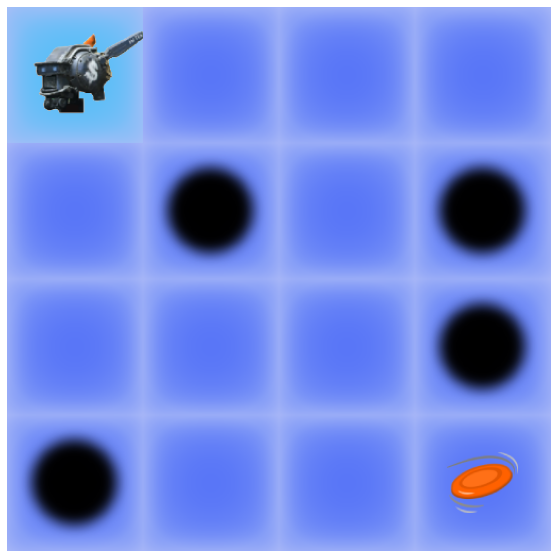

Episode 5000, Avg Reward (last 5000): 0.330
Episode 10000, Avg Reward (last 5000): 0.340


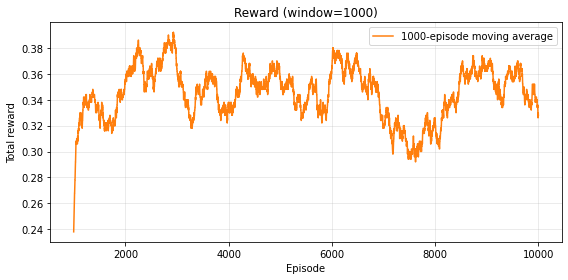

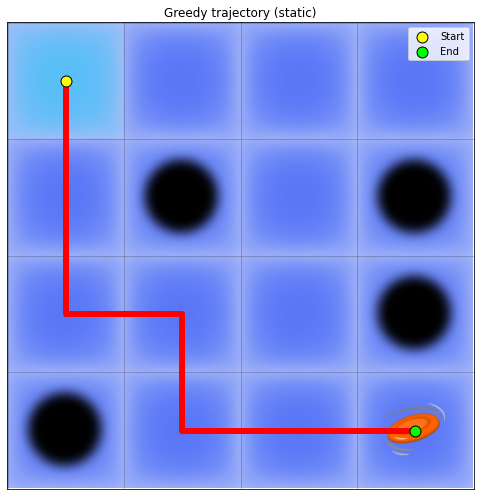

In [14]:
t1_env.reset()
plt.imshow(t1_env.render())
plt.axis('off')
plt.show()
Q_mc, rewards_mc = first_visit_mc_control(t1_env, episodes=10000, epsilon=0.3)
plot_rewards_moving_avg(rewards_mc, window=1000)
plot_trajectory_static(t1_env, Q_mc)

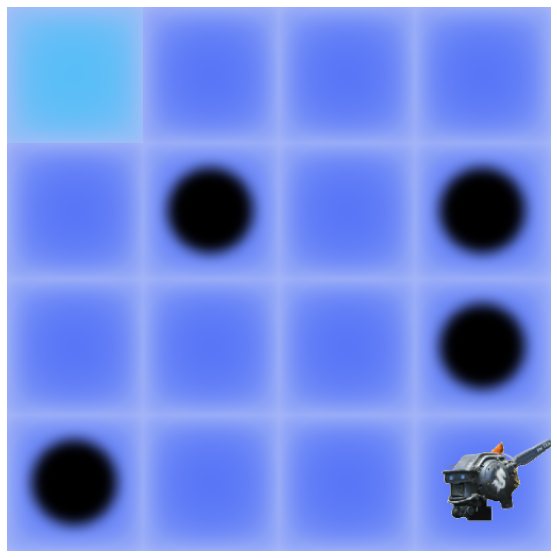

In [15]:
vis_mc(t1_env, Q_mc)

## Task 2 with First Visit Monte Carlo

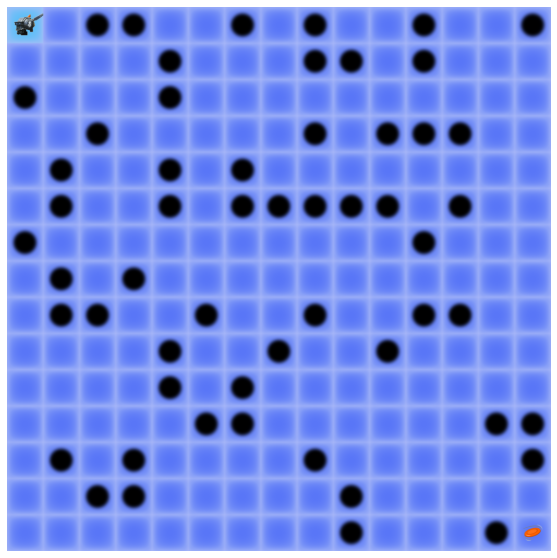

Episode 5000, Avg Reward (last 5000): -1.000
Episode 10000, Avg Reward (last 5000): -1.000
Episode 15000, Avg Reward (last 5000): -1.000
Episode 20000, Avg Reward (last 5000): -1.000
Episode 25000, Avg Reward (last 5000): -1.000


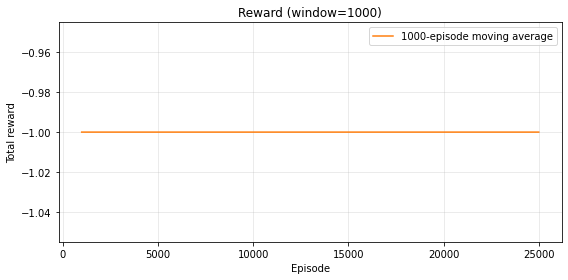

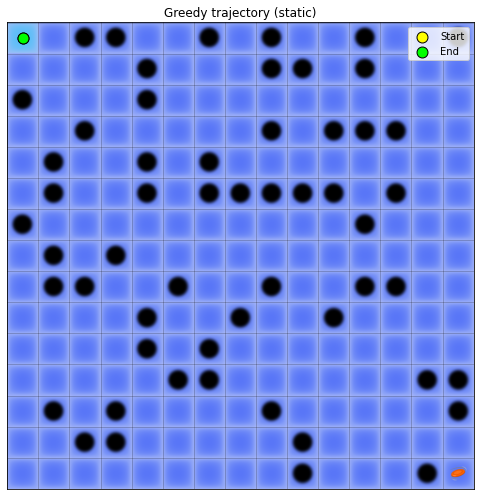

In [16]:
t2_env.reset()
plt.imshow(t2_env.render())
plt.axis('off')
plt.show()
# Tried for many many iterations and didn't get good results for big grids, robot either gets stuck or doesn't move from the start
Q_mc_2, rewards_mc_2 = first_visit_mc_control(t2_env,gamma=0.95, episodes=25000, epsilon=0.15)
plot_rewards_moving_avg(rewards_mc_2, window=1000)
plot_trajectory_static(t2_env, Q_mc_2)

# SARSA

In [17]:
def epsilon_greedy_action(Q, state, n_actions, epsilon):
    """Epsilon-greedy action selection."""
    if np.random.uniform() < epsilon:
        return np.random.choice(n_actions)
    return np.argmax(Q[state])

def sarsa(env, episodes=100000, alpha=0.2, gamma=0.9, alpha_decay=1, epsilon=0.15, epsilon_decay=0.99,epsilon_min=0.02, verbose=10000):
    """
    On-policy 1-step SARSA control.

    Returns:
        Q: Learned Q-table
        rewards_per_ep: Episode rewards
    """
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    #Q = np.zeros((n_states, n_actions))
    Q = np.ones((n_states, n_actions))*0.1
    rewards_per_ep = []

    for i in range(episodes):
        state, _ = env.reset()
        action = epsilon_greedy_action(Q, state, n_actions, epsilon)
        total_reward = 0
        done = False
        alpha*=alpha_decay
        while not done:
            next_state, reward, terminated, truncated, _ = env.step(action)
            next_action = epsilon_greedy_action(Q, next_state, n_actions, epsilon)

            # SARSA update: uses actual next_action
            td_target = reward + gamma * Q[next_state, next_action] * (not terminated)
            td_error = td_target - Q[state, action]

            Q[state, action] += alpha * td_error
            state, action = next_state, next_action
            total_reward += reward
            done = terminated or truncated

        rewards_per_ep.append(total_reward)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        if (i + 1) % verbose == 0:
            avg_reward = np.mean(rewards_per_ep[-verbose:])
            print(f"Episode {i+1}, Avg Reward (last {verbose}): {avg_reward:.3f}, Epsilon: {epsilon:.3f}")
            # if avg_reward>70:
            #     break
    return Q, rewards_per_ep

# Reuse your vis_mc or vis (works with Q-table)
def vis_sarsa(env, Q, ep=2, sl_t=0.2, end_sl_t=0.5):
    policy = np.argmax(Q, axis=1)
    for _ in range(ep):
        state, _ = env.reset()
        done = False
        while not done:
            clear_output(wait=True)
            plt.imshow(env.render())
            plt.axis('off')
            plt.show()
            sleep(sl_t)
            action = policy[state]
            state, _, done, truncated, _ = env.step(action)
            done = done or truncated
        clear_output(wait=True)
        plt.imshow(env.render())
        plt.axis('off')
        plt.show()
        sleep(end_sl_t)

# Usage:
# env = gym.make('FrozenLake-v1', is_slippery=True, render_mode='rgb_array')
#

## Task 1 using SARSA 

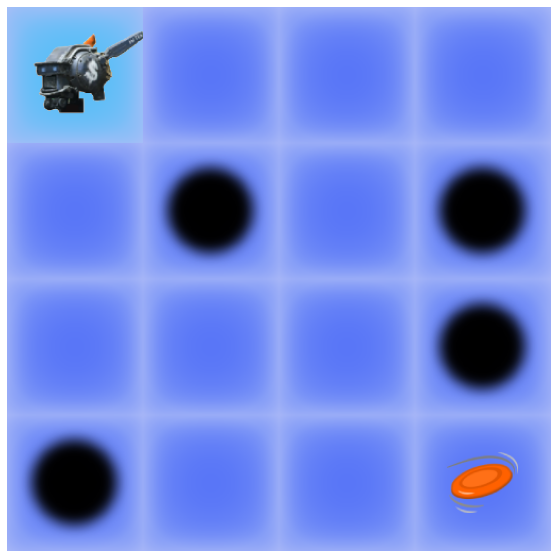

Episode 2500, Avg Reward (last 2500): 0.789, Epsilon: 0.100
Episode 5000, Avg Reward (last 2500): 0.773, Epsilon: 0.100


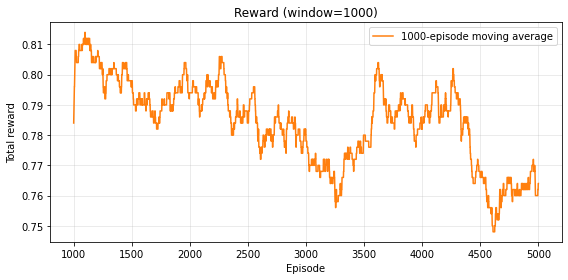

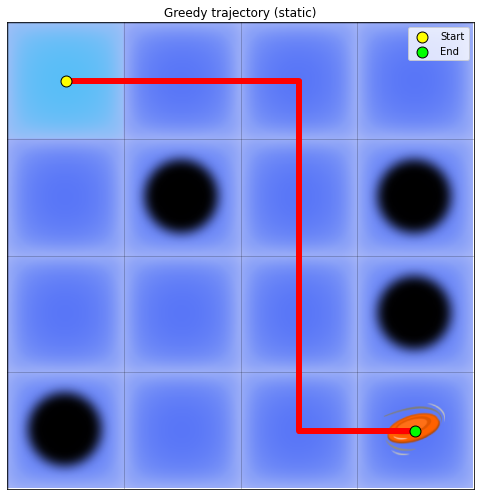

In [18]:
t1_env.reset()
plt.imshow(t1_env.render())
plt.axis('off')
plt.show()
Q_sarsa, rewards = sarsa(t1_env, episodes=5000,alpha=0.2, alpha_decay= 0.99999999, gamma=0.9, epsilon=0.1, epsilon_decay=1,verbose=2500)
plot_rewards_moving_avg(rewards, window=1000)
plot_trajectory_static(t1_env, Q_sarsa)

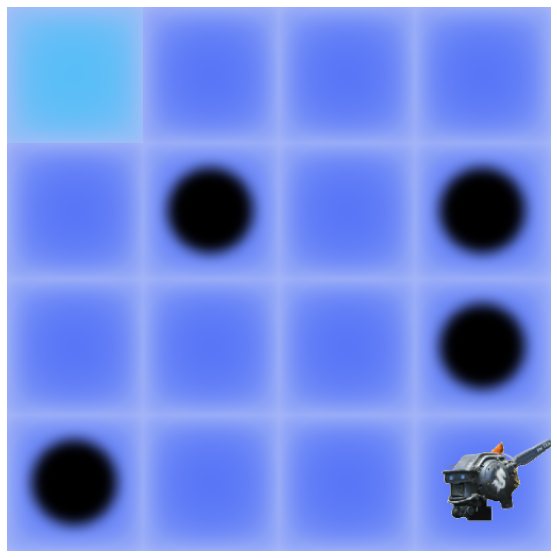

In [19]:
vis_sarsa(t1_env, Q_sarsa)

## Task 2 using SARSA 

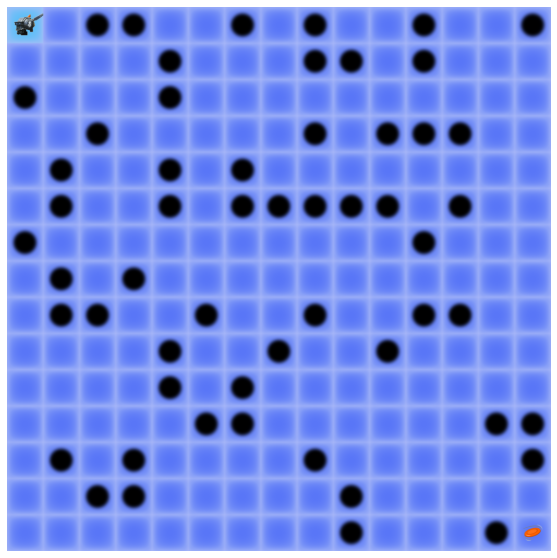

Episode 10000, Avg Reward (last 10000): -1.000, Epsilon: 0.273
Episode 20000, Avg Reward (last 10000): -1.000, Epsilon: 0.166
Episode 30000, Avg Reward (last 10000): -0.999, Epsilon: 0.100
Episode 40000, Avg Reward (last 10000): -0.997, Epsilon: 0.061
Episode 50000, Avg Reward (last 10000): -0.928, Epsilon: 0.037
Episode 60000, Avg Reward (last 10000): -0.759, Epsilon: 0.022
Episode 70000, Avg Reward (last 10000): -0.661, Epsilon: 0.020
Episode 80000, Avg Reward (last 10000): -0.537, Epsilon: 0.020
Episode 90000, Avg Reward (last 10000): -0.686, Epsilon: 0.020
Episode 100000, Avg Reward (last 10000): -0.719, Epsilon: 0.020


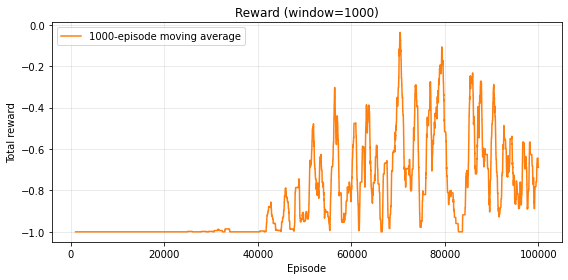

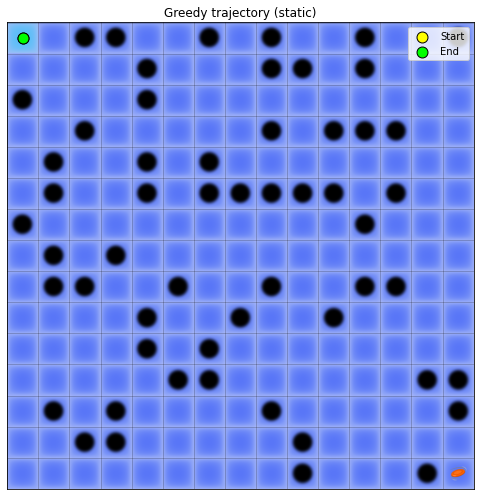

In [20]:
t2_env.reset()
plt.imshow(t2_env.render())
plt.axis('off')
plt.show()
Q_sarsa_2, rewards_2 = sarsa(t2_env, episodes=100000,alpha=0.4, alpha_decay= 0.99999999, gamma=0.9, epsilon=0.45, epsilon_decay=0.99995, verbose=10000)
plot_rewards_moving_avg(rewards_2, window=1000)
plot_trajectory_static(t2_env, Q_sarsa_2)

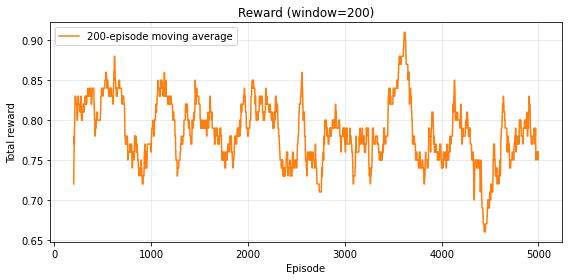

In [21]:
plot_rewards_moving_avg(rewards, window=200)


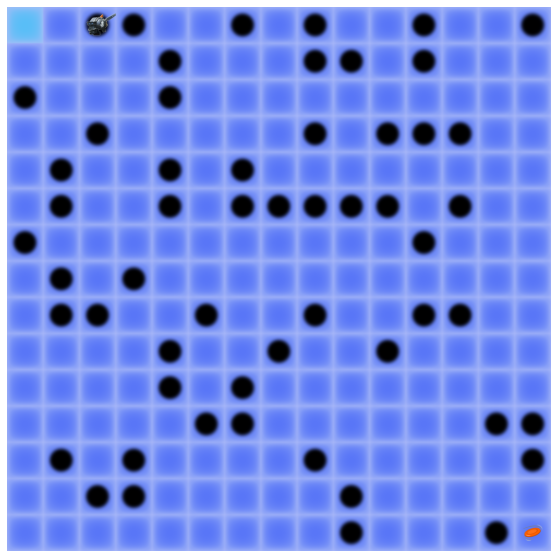

In [22]:
vis_sarsa(t2_env, Q_sarsa)

# Better DQN

In [23]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=128):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


def state_to_onehot(state, state_size):
    onehot = np.zeros(state_size, dtype=np.float32)
    onehot[state] = 1.0
    return onehot


class ReplayBuffer:
    """Preallocated numpy ring buffer — O(1) insert, O(batch) sample."""
    def __init__(self, capacity, state_size):
        self.capacity = capacity
        self.ptr = 0
        self.size = 0
        self.states      = np.zeros((capacity, state_size), dtype=np.float32)
        self.next_states = np.zeros((capacity, state_size), dtype=np.float32)
        self.actions     = np.zeros(capacity,               dtype=np.int64)
        self.rewards     = np.zeros(capacity,               dtype=np.float32)
        self.dones       = np.zeros(capacity,               dtype=np.float32)

    def push(self, state, action, reward, next_state, done):
        self.states[self.ptr]      = state
        self.next_states[self.ptr] = next_state
        self.actions[self.ptr]     = action
        self.rewards[self.ptr]     = reward
        self.dones[self.ptr]       = float(done)
        self.ptr  = (self.ptr + 1) % self.capacity
        self.size = min(self.size + 1, self.capacity)

    def sample(self, batch_size):
        idx = np.random.randint(0, self.size, size=batch_size)
        return (
            self.states[idx],
            self.actions[idx],
            self.rewards[idx],
            self.next_states[idx],
            self.dones[idx],
        )

    def __len__(self):
        return self.size


def DQN_train(
    env,
    episodes=20000,
    alpha=1e-3,
    gamma=0.9,
    epsilon=0.35,
    epsilon_min=0.01,
    epsilon_decay=0.9995,
    batch_size=64,           # larger batch for bigger grids
    replay_size=50000,       # bigger buffer for 400-625 state spaces
    target_update=200,       # steps between hard target updates
    hidden_size=128,         # wider for larger grids
    train_freq=4,            # train every N env steps (reduces redundancy)
    device='cuda',
    verbose=500,
):
    state_size  = env.observation_space.n
    action_size = env.action_space.n
    dev = torch.device(device)

    policy_net = DQN(state_size, action_size, hidden_size).to(dev)
    target_net = DQN(state_size, action_size, hidden_size).to(dev)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    # torch.compile speeds up repeated forward/backward on fixed-size inputs (PyTorch 2+)
    try:
        policy_net_compiled = torch.compile(policy_net)
    except Exception:
        policy_net_compiled = policy_net  # fallback for older PyTorch

    optimizer = optim.Adam(policy_net.parameters(), lr=alpha)
    buffer    = ReplayBuffer(replay_size, state_size)

    rewards_per_ep = []
    step_count = 0

    for ep in range(episodes):
        state, _ = env.reset()
        state_oh  = state_to_onehot(state, state_size)
        total_reward = 0.0
        done = False

        while not done:
            # Epsilon-greedy
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                with torch.no_grad():
                    s_t = torch.from_numpy(state_oh).unsqueeze(0).to(dev)
                    action = policy_net(s_t).argmax(dim=1).item()

            next_state, reward, terminated, truncated, _ = env.step(action)
            next_oh = state_to_onehot(next_state, state_size)
            done    = terminated or truncated

            buffer.push(state_oh, action, reward, next_oh, terminated)

            state_oh     = next_oh
            total_reward += reward
            step_count   += 1

            # Train every `train_freq` steps once buffer is large enough
            if len(buffer) >= batch_size and step_count % train_freq == 0:
                states_b, actions_b, rewards_b, next_states_b, dones_b = \
                    buffer.sample(batch_size)

                # Batch-convert once — no per-sample .to(device) calls
                s_b  = torch.from_numpy(states_b).to(dev)
                ns_b = torch.from_numpy(next_states_b).to(dev)
                a_b  = torch.from_numpy(actions_b).to(dev)
                r_b  = torch.from_numpy(rewards_b).to(dev)
                d_b  = torch.from_numpy(dones_b).to(dev)

                current_q = policy_net_compiled(s_b).gather(1, a_b.unsqueeze(1))

                with torch.no_grad():
                    next_q   = target_net(ns_b).max(1)[0]
                    target_q = r_b + gamma * next_q * (1.0 - d_b)

                loss = F.mse_loss(current_q.squeeze(), target_q)

                optimizer.zero_grad(set_to_none=True)  # faster than zero_grad()
                loss.backward()
                # Gradient clipping stabilizes training on larger grids
                torch.nn.utils.clip_grad_norm_(policy_net.parameters(), 10.0)
                optimizer.step()

            # Hard target update
            if step_count % target_update == 0:
                target_net.load_state_dict(policy_net.state_dict())

        rewards_per_ep.append(total_reward)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        if (ep + 1) % verbose == 0:
            avg = np.mean(rewards_per_ep[-verbose:])
            print(f"Episode {ep+1:>6} | Avg Reward (last {verbose}): {avg:.2f} | ε: {epsilon:.4f}")

    return policy_net, rewards_per_ep


# vis_dqn stays the same — no changes needed
def vis_dqn(env, model, ep=5, sl_t=0.5, end_sl_t=5, state_size=None, device='cpu'):
    from IPython.display import clear_output
    from time import sleep
    import matplotlib.pyplot as plt

    model.eval()
    dev = torch.device(device)
    model.to(dev)

    for _ in range(ep):
        state, _ = env.reset()
        done = False
        while not done:
            clear_output(wait=True)
            plt.imshow(env.render())
            plt.axis('off')
            plt.show()
            sleep(sl_t)

            s_oh = torch.from_numpy(
                state_to_onehot(state, state_size)
            ).unsqueeze(0).to(dev)
            with torch.no_grad():
                action = model(s_oh).argmax(1).item()
            state, reward, done, truncated, _ = env.step(action)
            done = done or truncated

        clear_output(wait=True)
        plt.imshow(env.render())
        plt.axis('off')
        plt.show()
        sleep(end_sl_t)


In [24]:
def rollout_greedy_dqn(env, model, state_size, device="cpu", max_steps_factor=10):
    """
    Roll out a greedy trajectory using the DQN policy network.
    Returns list of states visited.
    """
    import torch
    dev = torch.device(device)
    model.eval()
    model.to(dev)

    max_steps = env.nrows * env.ncols * max_steps_factor
    state, _ = env.reset()
    states = [state]

    done = False
    steps = 0
    while not done and steps < max_steps:
        state_oh = torch.from_numpy(
            state_to_onehot(state, state_size)
        ).unsqueeze(0).to(dev)

        with torch.no_grad():
            action = model(state_oh).argmax(dim=1).item()

        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        states.append(state)
        steps += 1

    return states


def plot_trajectory_static_dqn(env, model, state_size, device="cpu",
                                max_steps_factor=10,
                                path_color="yellow", path_width=6,
                                show_grid=True,
                                title="Greedy trajectory – DQN (static)"):
    """
    Draw a single static figure showing the DQN greedy path:
      - background  = tiled PNGs from env.image_dir (start/frozen/hole/goal)
      - overlay     = greedy path as a polyline through tile centres
    Falls back to colour-block rendering if images are unavailable.

    Parameters
    ----------
    env             : your diy_env instance
    model           : trained DQN policy network (nn.Module)
    state_size      : env.observation_space.n  (needed for one-hot encoding)
    device          : "cpu" or "cuda"
    max_steps_factor: trajectory cut-off = nrows * ncols * factor
    path_color      : matplotlib colour for the path line
    path_width      : line width in points
    show_grid       : overlay tile-boundary grid lines
    title           : figure title
    """
    import torch
    import numpy as np
    import matplotlib.pyplot as plt
    from PIL import Image

    # ---- 1. Roll out greedy trajectory ----
    states    = rollout_greedy_dqn(env, model, state_size,
                                   device=device,
                                   max_steps_factor=max_steps_factor)
    positions = [env._state_to_pos(s) for s in states]
    rows = np.array([r for r, c in positions], dtype=int)
    cols = np.array([c for r, c in positions], dtype=int)

    # ---- 2. Fallback if tile images are missing ----
    if getattr(env, "images", None) is None:
        # reuse your existing colour-block fallback
        return plot_trajectory_static_colorblocks(env,
                   # pass a dummy q_table of zeros – only path matters
                   q_table=None,
                   rows=rows, cols=cols)

    # ---- 3. Build tiled background canvas ----
    tile_size = env.images["frozen"].size[0]          # assumes square tiles
    canvas_w  = env.ncols * tile_size
    canvas_h  = env.nrows * tile_size
    canvas    = Image.new("RGBA", (canvas_w, canvas_h), (255, 255, 255, 255))

    for i in range(env.nrows):
        for j in range(env.ncols):
            val = env.map[i, j]
            if   val ==  1: tile_img = env.images["start"]
            elif val ==  2: tile_img = env.images["goal"]
            elif val == -1: tile_img = env.images["hole"]
            else:           tile_img = env.images["frozen"]
            canvas.paste(tile_img, (j * tile_size, i * tile_size), tile_img)

    bg = np.array(canvas.convert("RGB"))

    # ---- 4. Grid positions → pixel centres ----
    xs = cols * tile_size + tile_size / 2.0
    ys = rows * tile_size + tile_size / 2.0

    # ---- 5. Plot ----
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.imshow(bg, origin="upper")

    ax.plot(xs, ys,
            color=path_color, linewidth=path_width,
            marker="o", markersize=4)
    ax.scatter([xs[0]],  [ys[0]],  c="yellow", edgecolors="black",
               s=120, zorder=5, label="Start")
    ax.scatter([xs[-1]], [ys[-1]], c="lime",   edgecolors="black",
               s=120, zorder=5, label="End")

    if show_grid:
        ax.set_xticks(np.arange(0, canvas_w + 1, tile_size))
        ax.set_yticks(np.arange(0, canvas_h + 1, tile_size))
        ax.grid(True, color="black", linewidth=0.8, alpha=0.25)

    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(length=0)
    ax.set_title(title)
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()


## Task 2 with DQN

Episode   2000 | Avg Reward (last 2000): -1.00 | ε: 0.1921
Episode   4000 | Avg Reward (last 2000): -1.00 | ε: 0.1054
Episode   6000 | Avg Reward (last 2000): -1.00 | ε: 0.0578
Episode   8000 | Avg Reward (last 2000): 14.45 | ε: 0.0317
Episode  10000 | Avg Reward (last 2000): 88.23 | ε: 0.0174
Episode  12000 | Avg Reward (last 2000): 94.19 | ε: 0.0100
Episode  14000 | Avg Reward (last 2000): 95.76 | ε: 0.0100
Episode  16000 | Avg Reward (last 2000): 95.05 | ε: 0.0100
Episode  18000 | Avg Reward (last 2000): 95.66 | ε: 0.0100
Episode  20000 | Avg Reward (last 2000): 95.00 | ε: 0.0100
Episode  22000 | Avg Reward (last 2000): 95.71 | ε: 0.0100
Episode  24000 | Avg Reward (last 2000): 94.09 | ε: 0.0100


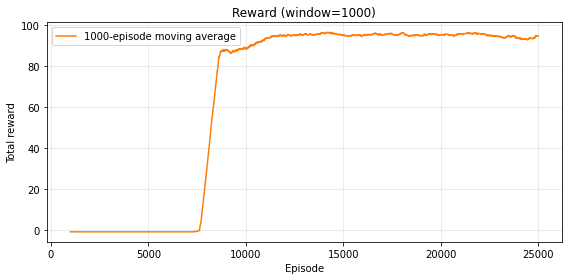

In [26]:
env = diy_env(
    map=task2_map,
    is_slippery=False,
    reward_schedule=(100,-1,0)
)

# Uncomment this line to train on GPU (only on supported devices)
# DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = 'cpu'

model, re_ep = DQN_train(
    env,
    episodes=25000,
    gamma=0.9,
    epsilon=0.35,
    epsilon_decay=0.9997,
    batch_size=64,
    replay_size=50000,
    hidden_size=128,
    target_update=200,
    train_freq=4,
    device=DEVICE,
    verbose=2000
)

plot_rewards_moving_avg(re_ep, window=1000)

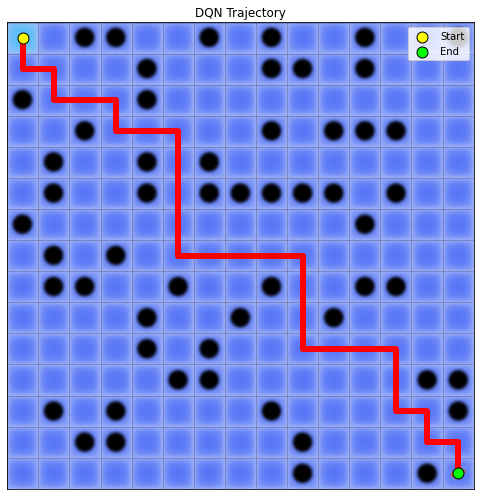

In [27]:
plot_trajectory_static_dqn(
    env        = env,          # your diy_env (task2map)
    model      = model,        # trained DQN policy network
    state_size = env.observation_space.n,
    device     = DEVICE,       # or "cpu"
    path_color = "red",
    title      = "DQN Trajectory"
)


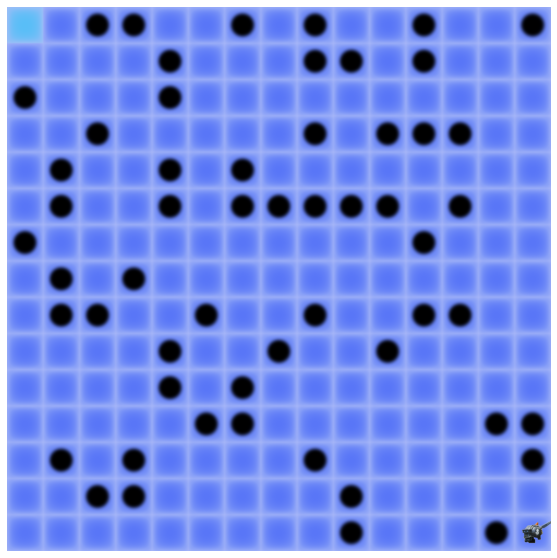

In [28]:
vis_dqn(env,model,ep=3, end_sl_t=0.5,state_size=env.observation_space.n)